In [1]:
# Install dependencies
!pip3 install -U spacy contractions beautifulsoup4 spacy-cleaner pyspellchecker requests pandas scikit-learn tqdm matplotlib seaborn keras tensorflow
!python3 -m spacy download en_core_web_lg

  Using cached spacy-3.5.4-cp310-cp310-macosx_11_0_arm64.whl (6.6 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 8.7 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [41]:
# Import statements
import re
from bs4 import BeautifulSoup
import contractions
from spellchecker import SpellChecker
import en_core_web_lg
import spacy
import requests
from tqdm.contrib.concurrent import process_map

import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Exploratory data analysis
imdb_data = pd.read_csv('input/imdb_dataset.csv')
print(imdb_data.head(10))
imdb_data.describe()

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
def normalize_review(review: str) -> str:
    '''Method to normalize (preprocess and lemmatize) a review into a tokenized list of words
    Steps:
      1. HTML decoding
      2. Lowercase conversion
      3. Contractions expansion
      4. Digits and punctuations removal
      5. Word tokenization
      6. Stop words removal and removal of insignificant words (less than 2 characters)
      7. Lemmatization

    Required Args
          review (str): Text to be preprocessed

    Returns
          str: Tokenized text
    '''
    # HTML decoding
    review = BeautifulSoup(review).get_text()
    # Convert words to lowercase
    review = review.lower()
    # Expand contractions
    review_list = []
    for word in review.split():
        review_list.append(contractions.fix(word))
    review = ' '.join(review_list)
    # Digits and punctuations removal
    review_list = re.sub('[^a-zA-Z0-9_]', ' ', review).split()
    review_list = [word for word in review_list if not re.search(r'\d', word)]
    review = ' '.join(review_list)
    # Word tokenization, stop word removal and lemmatization
    global nlp
    doc = nlp(review)
    tokenized_word_list = []
    for token in doc:
        if '_' in token.text:
            tokenized_word_list.append(token.text)
        elif not token.is_stop and len(token.text) > 1:
            # Lemmatization
            tokenized_word_list.append(token.lemma_)
    return ' '.join(tokenized_word_list)

In [5]:
# Data preprocessing
nlp = en_core_web_lg.load()
imdb_data['review'] = imdb_data['review'].apply(normalize_review)
imdb_data = imdb_data[['review', 'sentiment']]

/var/folders/zw/_nztlx510ng_bk9rwth0cg280000gn/T/ipykernel_86868/1956576779.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review).get_text()


In [6]:
imdb_data.head(10)

,review,sentiment
0,reviewer mention watch oz episode hook right e...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
5,probably time favorite movie story selflessnes...,positive
6,sure like resurrection date seahunt series tec...,positive
7,amazing fresh innovative idea air year brillia...,negative
8,encourage positive comment film look forward w...,negative
9,like original gut wrench laughter like movie y...,positive


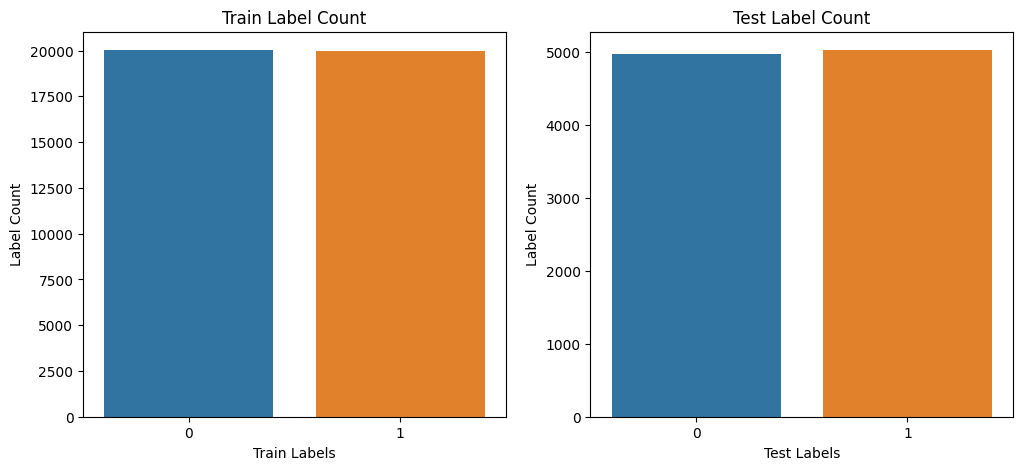

In [34]:
# Dataset splitting
sentiment_labels = imdb_data['sentiment']
vectorized_sentiment_labels = np.array(list(map(lambda x:1 if x=='positive' else 0, sentiment_labels)))
x_train, x_test, y_train, y_test = train_test_split(imdb_data.review, vectorized_sentiment_labels, test_size=0.2)

from collections import Counter

fig, ax = plt.subplots(1,2, figsize=(12,5))
for idx, group in enumerate([('Train', y_train), ('Test', y_test)]):
    data = Counter(group[1])
    sns.barplot(ax=ax[idx], x=list(data.keys()), y=list(data.values()))
    ax[idx].set_title(f'{group[0]} Label Count')
    ax[idx].set_xlabel(f'{group[0]} Labels')
    ax[idx].set_ylabel('Label Count')

plt.show()

In [36]:
def bow(train: list, test: list) -> tuple[list, list]:
    '''Method to use the Bag of Words (BOW) method to calculate the occurrence of words within a document
    
    Required Args
        train (list): Training dataset of movie reviews
        test (list): Testing dataset of movie reviews
    
    Returns
        list: Transformed training dataset reviews
        list: Transformed Testing dataset reviews
    '''
    # Initialize vectorizer
    cv=CountVectorizer()
    # Transform training dataset
    transformed_train=cv.fit_transform(train)
    # Transform testing dataset
    transformed_test=cv.transform(test)
    return transformed_train, transformed_test

In [37]:
# BOW Vectorization
bow_transformed_train, bow_transformed_test = bow(x_train, x_test)
print('BOW Train: ', bow_transformed_train.shape)
print('BOW Test: ', bow_transformed_test.shape)

BOW Train:  (40000, 77943)
BOW Test:  (10000, 77943)


In [38]:
def tfidf(train: list, test: list) -> tuple[list, list]:
    '''Method to use the Term Frequency Inverse Document Frequency (TF-IDF) method to calculate how relevant a word in a series or corpus is to a text
    
    Required Args
        train (list): Training dataset of movie reviews
        test (list): Testing dataset of movie reviews
    
    Returns
        list: Transformed training dataset reviews
        list: Transformed Testing dataset reviews
    '''
    # Initialize vectorizer
    tfidf=TfidfVectorizer()
    # Transform training dataset
    transformed_train=tfidf.fit_transform(train)
    # Transform testing dataset
    transformed_test=tfidf.transform(test)
    return transformed_train, transformed_test

In [39]:
# TF-IDF Vectorization
tfidf_transformed_train, tfidf_transformed_test = tfidf(x_train, x_test)
print('TFIDF Train: ', tfidf_transformed_train.shape)
print('TFIDF Test: ', tfidf_transformed_test.shape)

TFIDF Train:  (40000, 77943)
TFIDF Test:  (10000, 77943)


              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4973
           1       0.87      0.84      0.85      5027

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000


Spending time:  0.016911029815673828



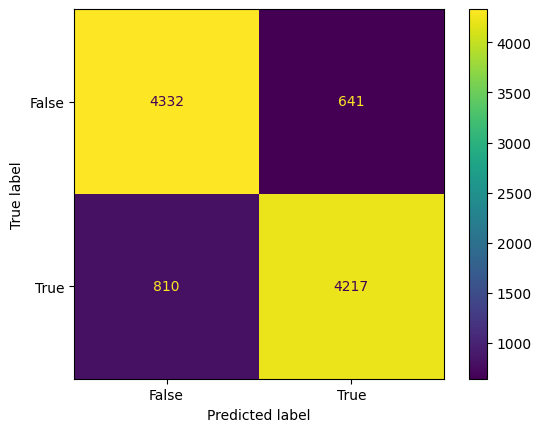

In [40]:
# BOW + Multinomial Naive Bayes Classifier
bow_nb_start = time.time()
bow_nb = MultinomialNB()
bow_nb.fit(bow_transformed_train, y_train)
bow_nb_end = time.time()
bow_nb_y_pred = bow_nb.predict(bow_transformed_test)
print(classification_report(y_test, bow_nb_y_pred))
print()
print('Spending time: ', bow_nb_end - bow_nb_start)
print()
bow_nb_cm = confusion_matrix(y_test, bow_nb_y_pred)
bow_nb_cm_display = ConfusionMatrixDisplay(confusion_matrix=bow_nb_cm, display_labels=[False, True])
bow_nb_cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4973
           1       0.86      0.85      0.85      5027

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Spending time:  54.700690031051636



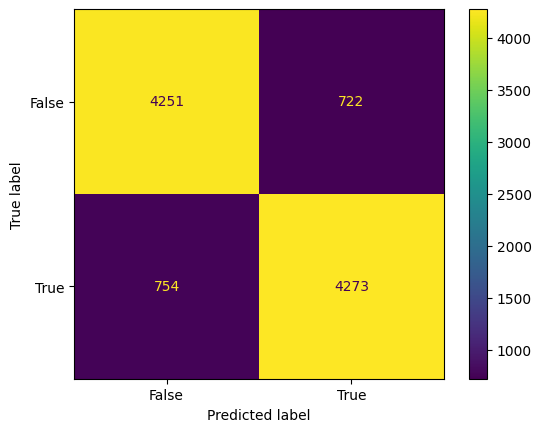

In [43]:
# BOW + Random Forest Classifier
bow_rfc_start = time.time()
bow_rfc = RandomForestClassifier()
bow_rfc.fit(bow_transformed_train, y_train)
bow_rfc_end = time.time()
bow_rfc_y_pred = bow_rfc.predict(bow_transformed_test)
print(classification_report(y_test, bow_rfc_y_pred))
print()
print('Spending time: ', bow_rfc_end - bow_rfc_start)
print()
bow_rfc_cm = confusion_matrix(y_test, bow_rfc_y_pred)
bow_rfc_cm_display = ConfusionMatrixDisplay(confusion_matrix=bow_rfc_cm, display_labels=[False, True])
bow_rfc_cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      4973
           1       0.64      0.67      0.65      5027

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000


Spending time:  0.016360044479370117



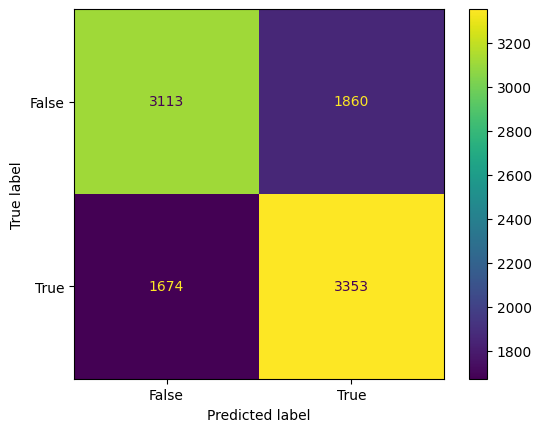

In [45]:
# BOW + K Nearest Neighors Classifier
bow_knn_start = time.time()
bow_knn = KNeighborsClassifier()
bow_knn.fit(bow_transformed_train, y_train)
bow_knn_end = time.time()
bow_knn_y_pred = bow_knn.predict(bow_transformed_test)
print(classification_report(y_test, bow_knn_y_pred))
print()
print('Spending time: ', bow_knn_end - bow_knn_start)
print()
bow_knn_cm = confusion_matrix(y_test, bow_knn_y_pred)
bow_knn_cm_display = ConfusionMatrixDisplay(confusion_matrix=bow_knn_cm, display_labels=[False, True])
bow_knn_cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4973
           1       0.87      0.85      0.86      5027

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


Spending time:  0.01255488395690918



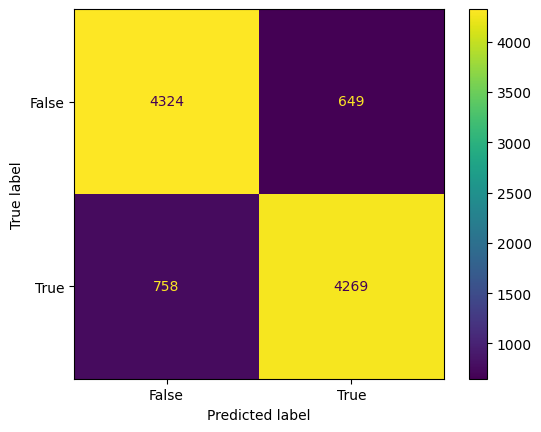

In [48]:
# TFIDF + Multinomial Naive Bayes Classifier
tfidf_nb_start = time.time()
tfidf_nb = MultinomialNB()
tfidf_nb.fit(tfidf_transformed_train, y_train)
tfidf_nb_end = time.time()
tfidf_nb_y_pred = tfidf_nb.predict(tfidf_transformed_test)
print(classification_report(y_test, tfidf_nb_y_pred))
print()
print('Spending time: ', tfidf_nb_end - tfidf_nb_start)
print()
tfidf_nb_cm = confusion_matrix(y_test, tfidf_nb_y_pred)
tfidf_nb_cm_display = ConfusionMatrixDisplay(confusion_matrix=tfidf_nb_cm, display_labels=[False, True])
tfidf_nb_cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4973
           1       0.86      0.85      0.85      5027

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Spending time:  52.6169593334198



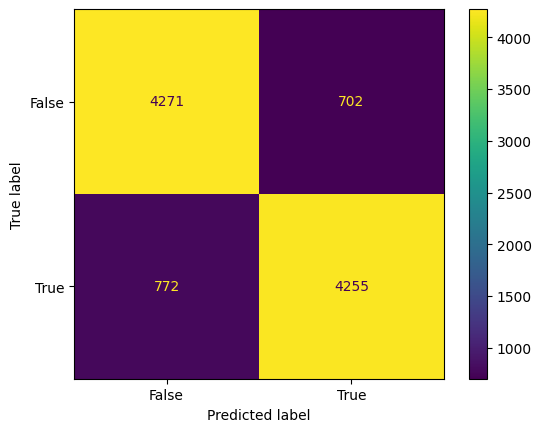

In [49]:
# TFIDF + Random Forest Classifier
tfidf_rfc_start = time.time()
tfidf_rfc = RandomForestClassifier()
tfidf_rfc.fit(tfidf_transformed_train, y_train)
tfidf_rfc_end = time.time()
tfidf_rfc_y_pred = tfidf_rfc.predict(tfidf_transformed_test)
print(classification_report(y_test, tfidf_rfc_y_pred))
print()
print('Spending time: ', tfidf_rfc_end - tfidf_rfc_start)
print()
tfidf_rfc_cm = confusion_matrix(y_test, tfidf_rfc_y_pred)
tfidf_rfc_cm_display = ConfusionMatrixDisplay(confusion_matrix=tfidf_rfc_cm, display_labels=[False, True])
tfidf_rfc_cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      4973
           1       0.75      0.85      0.80      5027

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000


Spending time:  0.01613616943359375



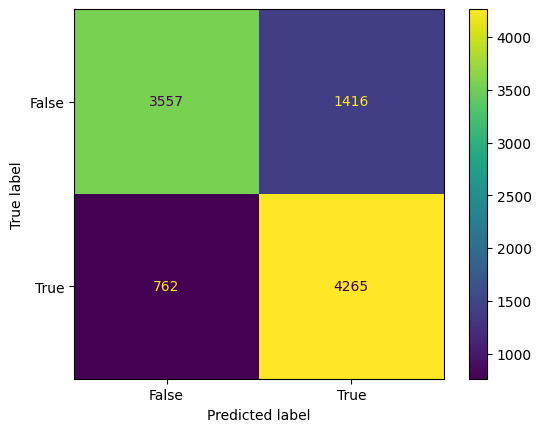

In [50]:
# TFIDF + K Nearest Neighors Classifier
tfidf_knn_start = time.time()
tfidf_knn = KNeighborsClassifier()
tfidf_knn.fit(tfidf_transformed_train, y_train)
tfidf_knn_end = time.time()
tfidf_knn_y_pred = tfidf_knn.predict(tfidf_transformed_test)
print(classification_report(y_test, tfidf_knn_y_pred))
print()
print('Spending time: ', tfidf_knn_end - tfidf_knn_start)
print()
tfidf_knn_cm = confusion_matrix(y_test, tfidf_knn_y_pred)
tfidf_knn_cm_display = ConfusionMatrixDisplay(confusion_matrix=tfidf_knn_cm, display_labels=[False, True])
tfidf_knn_cm_display.plot()
plt.show()

In [51]:
# Save model
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_nb, handle)